In [1]:
%matplotlib inline
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
from os import path

In [2]:
##### setting #####
# folder path for saving images
path_images = "./images/"
# path of camera calibration video
path_cam_cal = "videos/scheibe/500p/C0595.MP4"
path_cam_cal = "videos/scheibe/1000p/C0602.MP4"
# row number of chessboard
n_row = 4
# column number of chessboard
n_column = 4
# size of box [mm]
size_box = 0.04
# size of aruco [mm]
size_aruco = 0.03            
# size of chessboard [pixel]   
size_chessboard = (2000,2000) 

In [3]:
# generate chessboard
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
chessboard = aruco.CharucoBoard_create(n_column, n_row, size_box, size_aruco, aruco_dict)
imboard = chessboard.draw(size_chessboard)

if not path.exists(path_images):
    os.mkdir(path_images)
cv2.imwrite(path_images + "chessboard.tiff", imboard)

True

In [4]:
# convert video to images

n_images = 100
if not path.exists(path_cam_cal):
    raise Exception('No video for calibration! path:' + path_cam_cal)
if not path.exists(path_images + "camera_cal/"):
    os.mkdir(path_images + "camera_cal/")

cap = cv2.VideoCapture(path_cam_cal)
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
distance = num_frames//n_images
frame_id = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if (ret is not True):
            break
    if num_frames <= n_images:
        filename = path_images + "camera_cal/image_" +  frame_id + ".jpg"
        cv2.imwrite(filename, frame)
    elif frame_id<n_images*distance and frame_id%distance == 0:
        #   frame = cv2.rotate(frame,cv2.ROTATE_90_CLOCKWISE)
        filename = path_images + "camera_cal/image_" +  str(int(frame_id//distance)) + ".jpg"
        cv2.imwrite(filename, frame)
    frame_id += 1
cap.release()
print ("Convertion done!")

Convertion done!


In [5]:
# load images
images = np.array([path_images + 'camera_cal/'  + f for f in os.listdir(path_images+'camera_cal/') if f.endswith(".jpg") ])
order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
images = images[order]

In [6]:
# read_chessboards
"""
Charuco base pose estimation.
"""
print("POSE ESTIMATION STARTS:")
all_corners = []
all_ids = []
# SUB PIXEL CORNER DETECTION CRITERION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

for im in images:
    print("=> Processing image {0}".format(im))
    frame = cv2.imread(im)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
    if len(corners)>0:
        # SUB PIXEL DETECTION
        for corner in corners:
            cv2.cornerSubPix(gray, corner, 
                             winSize = (3,3), 
                             zeroZone = (-1,-1), 
                             criteria = criteria)
        res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,chessboard)        
        if res2[1] is not None and res2[2] is not None and len(res2[1])>3:
            all_corners.append(res2[1])
            all_ids.append(res2[2])              
imsize = gray.shape


POSE ESTIMATION STARTS:
=> Processing image ./images/camera_cal/image_0.jpg
=> Processing image ./images/camera_cal/image_1.jpg
=> Processing image ./images/camera_cal/image_2.jpg
=> Processing image ./images/camera_cal/image_3.jpg
=> Processing image ./images/camera_cal/image_4.jpg
=> Processing image ./images/camera_cal/image_5.jpg
=> Processing image ./images/camera_cal/image_6.jpg
=> Processing image ./images/camera_cal/image_7.jpg
=> Processing image ./images/camera_cal/image_8.jpg
=> Processing image ./images/camera_cal/image_9.jpg
=> Processing image ./images/camera_cal/image_10.jpg
=> Processing image ./images/camera_cal/image_11.jpg
=> Processing image ./images/camera_cal/image_12.jpg
=> Processing image ./images/camera_cal/image_13.jpg
=> Processing image ./images/camera_cal/image_14.jpg
=> Processing image ./images/camera_cal/image_15.jpg
=> Processing image ./images/camera_cal/image_16.jpg
=> Processing image ./images/camera_cal/image_17.jpg
=> Processing image ./images/cam

In [7]:
print(imsize)

(1080, 1920)


In [8]:
def camera_calibrate(chessboard, all_corners, all_ids, imsize, camera_mtx_init, dist_coeff_init):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
#     cameraMatrixInit = np.array([[ 3000.,    0., imsize[0]/2.],
#                                  [    0., 3000., imsize[1]/2.],
#                                  [    0.,    0.,           1.]])
    
#     flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
#     flags = (cv2.CALIB_USE_INTRINSIC_GUESS)
    
    flags = ( cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_ZERO_TANGENT_DIST + cv2.CALIB_FIX_K1 + cv2.CALIB_FIX_K2 + cv2.CALIB_FIX_K3 ) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners = all_corners,
                      charucoIds = all_ids,
                      board = chessboard,
                      imageSize = imsize,
                      cameraMatrix = camera_mtx_init,
                      distCoeffs = dist_coeff_init,
                      flags = flags,
                      criteria = (cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

#     (ret, camera_matrix, distortion_coefficients0, 
#      rotation_vectors, translation_vectors) = cv2.aruco.calibrateCameraCharuco(
#                       charucoCorners=all_corners,
#                       charucoIds=all_ids,
#                       board=board,
#                       imageSize=imsize,
#                       cameraMatrix = None,
#                       distCoeffs = None)
    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [9]:
# camera calibration
camera_mtx_init = np.array([[ 1500,    0, imsize[1]/2],
                            [   0, 1500, imsize[0]/2],
                            [   0,    0,           1]])

dist_coeff_init = np.zeros((5,1))
%time ret, mtx, dist, rvecs, tvecs = camera_calibrate(chessboard, all_corners, all_ids, imsize, camera_mtx_init, dist_coeff_init)

CAMERA CALIBRATION
Wall time: 1min 45s


In [10]:
print(mtx)
print(dist)

[[2.14390549e+03 0.00000000e+00 9.72643627e+02]
 [0.00000000e+00 2.14390549e+03 5.54473535e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [53]:
print(mtx)
print(dist)

[[1.44149483e+03 0.00000000e+00 9.72727627e+02]
 [0.00000000e+00 1.44149483e+03 5.29007602e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[0.00674596]
 [0.1925568 ]
 [0.        ]
 [0.        ]
 [0.00790059]]


In [11]:
# save results
np.savetxt("cam_mtx.csv", mtx)
np.savetxt("cam_dist.csv", dist)

In [13]:
mtx = np.loadtxt("cam_mtx.csv")
dist = np.loadtxt("cam_dist.csv")
# mtx[0,2] = -1000
print(mtx)
print(dist)

[[1.41194449e+03 0.00000000e+00 9.61743314e+02]
 [0.00000000e+00 1.41194449e+03 5.10715760e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[0. 0. 0. 0. 0.]


(-0.5, 1919.5, 1079.5, -0.5)

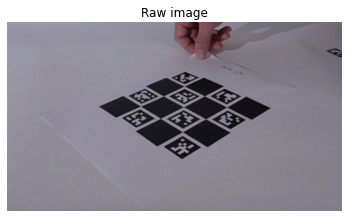

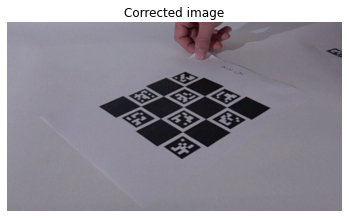

In [12]:
# Check calibration results
plt.figure()
frame = cv2.imread(images[0])
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.figure()
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")